# Supporting information

This notebook can be run to analyse and plot data supporting *Theory of flow-induced covalent polymer mechanochemistry in dilute solutions*, by Etienne Rognin, Niamh Willis-Fox, and Ronan Daly.

## Contents

1. Importing bead-rod simulations and looking at polymer unravelling
2. Building models of the distribution of intact chains
3. Mechanochemical activation versus scission
4. Model validation

First, we import Python packages:

In [1]:
import numpy as np

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from tqdm.notebook import tqdm
from scipy.optimize import minimize


plt.rcParams.update({
    "text.usetex": True,
    "font.size": 12,
    "font.family": "serif",
    "font.serif": "newcent",
    "text.latex.preamble": "\\usepackage[T1]{fontenc}\n\\usepackage{fourier}",
    
})

## 1. Importing bead-rod molecular dynamics simulations and looking at polymer unravelling

Here we import data from bead-rod model simulations. The data is in the `bead-rod_dataset` folder, simulations are stored in numpy `npz` binary files. The data is imported using `np.load` function which creates a Python dictionary for each simulation file. This dictionary contains the following labels:
1. `t` the time axis.
2. `gradU` the time series of velocity gradients used as forcing terms in the bead-rod simulation.
3. `g_max` the time series of the maximum tensile force, for each molecule of the simulation ensemble.
4. `i_max` the time series of the positions of the maximum force in the chain (not used in this study)
3. `g_12` the time series of the tensile force at the center of the chain, for each molecule.
4. `A_average` the time series of the average conformation tensor (second-order moment of the end-to-end vector). Used in section 4 for model validation.

Note that the bead-rod algorithm and dimension normalization are described in a previous study (see Rognin et al. https://www.repository.cam.ac.uk/bitstream/1810/279443/1/multiscale_revision_clean.pdf)

In [2]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 1000                      # Number of segments in the Kramers chain
n_ensemble = 1000                   # Number of molecules to simulate

# Input folder
data_folder = 'bead-rod_dataset'
                    
# Name: file
scenarios = [
    'contraction_0',
    'sonication_0',
    'elongation_0_noBF',
    'elongation_0_noBF_DP1.01',
]

# Load data
dataset = {}
for scenario in scenarios:
    with np.load(f"{data_folder}/{scenario}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}.npz") as data:
        temp = dict(data)
        
        # Get velocity gradient, normalize and get strain rate as max eigenvalue
        temp['∇U'] = temp.pop('gradU')
        temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
        
        temp['epsilon_dot'] = np.linalg.eigvalsh(0.5*(temp['∇U'] + temp['∇Uᵀ']))[:,2]
        
        # Integrated strain
        temp['epsilon'] = np.zeros_like(temp['t'])
        temp['epsilon'][1:] = np.cumsum(np.diff(temp['t'])*temp['epsilon_dot'][:-1])
        
        # Normalized effective square segment
        g_maxf = temp['g_max'].copy()
        g_maxf[g_maxf<4] = 0
        temp['L2'] = 8/n_links**2 * g_maxf/(temp['epsilon_dot'] + 1e-12)
        
        # Normalized effective segment for centered mechanophore
        g_12f = temp['g_12'].copy()
        g_12f[g_12f<4] = 0
        temp['M2'] = 8/n_links**2 * g_12f/(temp['epsilon_dot'] + 1e-12)
        
        # Effective segment at one third of the chain
        #g_13f = temp['g_13'].copy()


        # Save
        dataset[scenario] = temp
        

# Load data with HI
with np.load(f"{data_folder}/elongation_0_noBF_poly_HI_nlinks1000_nmol100_merged.npz") as data:
    temp = dict(data)
    g_max_unravel = 151524.9999999543*0.06800914093207841
    temp['L2'] = temp['g_max']/g_max_unravel
    temp['M2'] = temp['g_12']/g_max_unravel

    # Save
    dataset['HI'] = temp

# Equivalent without HI
with np.load(f"{data_folder}/elongation_0_noBF_poly_noHI_nlinks1000_nmol16.npz") as data:
    temp = dict(data)
    g_max_unravel = 151524.9999999543
    temp['L2'] = temp['g_max']/g_max_unravel
    temp['M2'] = temp['g_12']/g_max_unravel

    # Save
    dataset['noHI'] = temp

### Plot examples of polymer unraveling (figure 1)

/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


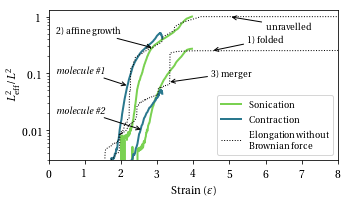

In [3]:
plt.rcParams['figure.figsize'] = [5, 3]
fig, ax = plt.subplots(ncols=1)

# Molecule 1
ax.semilogy(dataset['sonication_0']['epsilon'][:-142], dataset['sonication_0']['L2'][3,:-142], color='#7ad151', linewidth=2, label='Sonication')
ax.semilogy(dataset['contraction_0']['epsilon'][:-90], dataset['contraction_0']['L2'][3,:-90], color='#2a788e', linewidth=2, label='Contraction')
ax.semilogy(dataset['elongation_0_noBF']['epsilon'], dataset['elongation_0_noBF']['L2'][3], ls=':', color='k', linewidth=1, label='Elongation without\nBrownian force')    

# other example
i = 2
ax.semilogy(dataset['sonication_0']['epsilon'][:-142], dataset['sonication_0']['L2'][i,:-142], color='#7ad151', linewidth=2)
ax.semilogy(dataset['contraction_0']['epsilon'][:-90], dataset['contraction_0']['L2'][i,:-90], color='#2a788e', linewidth=2)
ax.semilogy(dataset['elongation_0_noBF']['epsilon'], dataset['elongation_0_noBF']['L2'][i], ls=':', color='k', linewidth=1)    

# Labels
ax.annotate('unravelled', xy=(5, 1), xytext=(6, 0.6), arrowprops=dict(arrowstyle="->"), fontsize=10)
ax.annotate('1) folded', xy=(4.5, 0.25), xytext=(5.5, 0.35), arrowprops=dict(arrowstyle="->"), fontsize=10)
ax.annotate('3) merger', xy=(3.3, 0.07), xytext=(4.5, 0.09), arrowprops=dict(arrowstyle="->"), fontsize=10)
ax.annotate('2) affine growth', xy=(2.9, 0.28), xytext=(0.2, 0.5), arrowprops=dict(arrowstyle="->"), fontsize=10)
ax.annotate(r'\textit{molecule \#1}', xy=(2.2, 0.06), xytext=(0.2, 0.1), arrowprops=dict(arrowstyle="->"), fontsize=10)
ax.annotate(r'\textit{molecule \#2}', xy=(2.6, 0.01), xytext=(0.2, 0.02), arrowprops=dict(arrowstyle="->"), fontsize=10)

ax.set_xlabel(r'Strain ($\varepsilon$)')
ax.set_xlim(0,8)
ax.set_ylabel(r'$L_\mathrm{eff}^2/L^2$', labelpad=0)
ax.set_ylim(0.003,1.3)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.legend(fontsize=10)


plt.tight_layout()
#plt.savefig('plot_molecules.pdf') 

## 2. Building models of the distribution of intact chains

From the distributions of $L^2_\mathrm{eff}$ we can get the distribution of intact chains.

In [4]:
def get_distribution(data, ws):
    """Get distribution of intact chains from uniaxial elongation
    
    Parameters
    ----------
    data: dict
        Dictionary of imported bead-rod simulation.
    ws: ndarray
        Array of strain rates normalized by the critical strain rate.
        
    Returns
    -------
    ndarray:
        Distribution of intact chains according to the bead-rod simulations.
    """
    
    n_ensemble = data['L2'].shape[0]
    
    c = np.zeros((len(ws), len(data['t'])))
    
    for i, w in enumerate(tqdm(ws)):
        events = np.zeros_like(data['t'])
        
        # Loop over molecules
        for molecule in data['L2']:
            # Loop over time (this is long but prevents non monotonic effects when HI are on)
            for j, L2_ in enumerate(molecule):
                if L2_ > 1./w:
                    events[j] += 1
                    break
        c[i] = 1. - np.cumsum(events)/n_ensemble
            
    return c
    
    
# w range
ws = np.logspace(-1,2,100)

# Monodispersed enesemble
c_mono = get_distribution(dataset['elongation_0_noBF'], ws)    

# Polydispersed enesemble
c_poly = get_distribution(dataset['elongation_0_noBF_DP1.01'], ws)   

# Hydrodynamic interactions
c_HI = get_distribution(dataset['HI'], ws) 

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


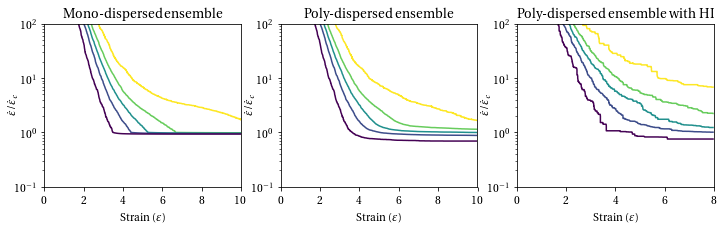

In [5]:
# Quick check

plt.rcParams['figure.figsize'] = [12, 3]
fig, ax = plt.subplots(ncols=3)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
ax[0].contour(dataset['elongation_0_noBF']['epsilon'], ws, c_mono, levels, cmap='viridis_r')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'Strain ($\varepsilon$)')
ax[0].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[0].set_title('Mono-dispersed ensemble')

ax[1].contour(dataset['elongation_0_noBF_DP1.01']['epsilon'], ws, c_poly, levels, cmap='viridis_r')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'Strain ($\varepsilon$)')
ax[1].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[1].set_title('Poly-dispersed ensemble')

ax[2].contour(dataset['HI']['t'], ws, c_HI, levels, cmap='viridis_r')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'Strain ($\varepsilon$)')
ax[2].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[2].set_title('Poly-dispersed ensemble with HI')

plt.show()

### Model fit

We fit the contour plot with this expression:
\begin{equation}
    -\ln c(h, w) = \kappa w^\alpha F\left(\frac{\ln w}{\gamma_0} \right)\gamma_1 G\left(\frac{h+\beta \ln w}{\gamma_1} \right)
    \label{eq:c}
\end{equation}
where $h=\varepsilon - \ln \xi$, $w=\dot\varepsilon/\dot\varepsilon_c$, and with $F(x)=(1 + \exp(-x))^{-1}$ and $G(x)=\ln \left(1 + \exp(x)\right)$.

In [6]:
def build_model(params, epsilons, ws, n_links):
    """Build a model (2D map) of intact chains.
    
    Parameters
    ----------
    params: list of floats
        Parameters of the model.
    epsilons: ndarray (M,)
        Strain axis.
    ws: ndarray (N,)
        Normalized strain rate axis.
    n_links: int
        Number (of average number) of links in a chain (this is used to compute extensibility).
        
    Returns
    -------
    ndarray (N, M)
        Proportion of intact chains according to the model.
    """
    c_model = np.ones((len(ws), len(epsilons)))
    kappa, alpha, beta, gamma0, gamma1 = params
    
    for i, w in enumerate(ws):
        f = 1./(1 + np.exp(-np.log(w)/gamma0))
        g = gamma1*np.log((1 + np.exp((epsilons - np.log(n_links)/2 + beta*np.log(w))/gamma1)))
        
        c_model[i] = np.exp(-kappa*w**alpha*f*g)
        
    return c_model

### Monodispersed ensemble

In [7]:
def loss(params):
    s = np.sum((c_mono-build_model(params, dataset['elongation_0_noBF']['epsilon'], ws, 1000))**2)
    print(s, end='\r')
    return s


res = minimize(loss, [0.4, 0.6, 0.25, 0.01, 0.15])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['𝜅', '𝛼', '𝛽', '𝛾0', '𝛾1', ]
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

c_mono_model = build_model(res.x, dataset['elongation_0_noBF']['epsilon'], ws, 1000)

Optimization terminated successfully.
𝜅 = 0.428 ± 0.013
𝛼 = 0.638 ± 0.032
𝛽 = 0.253 ± 0.013
𝛾0 = 0.011 ± 0.014
𝛾1 = 0.175 ± 0.017


### Polydispersed ensemble

In [8]:
def loss(params):
    s = np.sum((c_poly-build_model(params, dataset['elongation_0_noBF_DP1.01']['epsilon'], ws, 1000))**2)
    print(s, end='\r')
    return s


res = minimize(loss, [0.32, 0.9, 0.25, 0.1, 0.2])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['𝜅', '𝛼', '𝛽', '𝛾0', '𝛾1', ]
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

c_poly_model = build_model(res.x, dataset['elongation_0_noBF_DP1.01']['epsilon'], ws, 1000)

# Save for later:
params_ratio1 = res.x

Optimization terminated successfully.
𝜅 = 0.320 ± 0.009
𝛼 = 0.894 ± 0.044
𝛽 = 0.183 ± 0.019
𝛾0 = 0.095 ± 0.006
𝛾1 = 0.222 ± 0.017


### Hydrodynamic interactions

In [9]:
def loss(params):
    s = np.sum((c_HI-build_model(params, dataset['HI']['t'], ws, 1000))**2)
    print(s, end='\r')
    return s


res = minimize(loss, [0.15, 0.8, 0.25, 0.1, 0.2])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['𝜅', '𝛼', '𝛽', '𝛾0', '𝛾1', ]
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

c_HI_model = build_model(res.x, dataset['HI']['t'], ws, 1000)

Optimization terminated successfully.
𝜅 = 0.148 ± 0.006
𝛼 = 0.849 ± 0.036
𝛽 = 0.271 ± 0.017
𝛾0 = 0.120 ± 0.023
𝛾1 = 0.196 ± 0.025


Inspect the result:

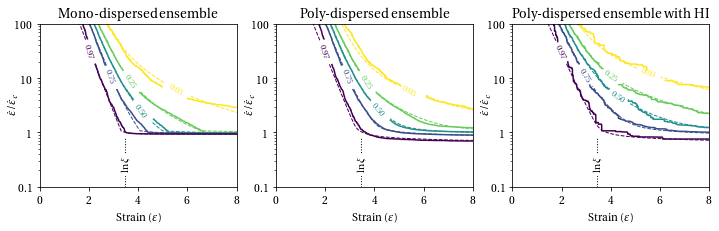

In [10]:
plt.rcParams['figure.figsize'] = [12, 3]
fig, ax = plt.subplots(ncols=3)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]
#ccols = ['#dde318', '#5ec962', '#21918c', '#3b528b', '#440154']

epsilons = dataset['elongation_0_noBF']['epsilon']


CS1 = ax[0].contour(epsilons, ws, c_mono_model, levels, cmap='viridis_r', linestyles='dashed', linewidths=1)
CS = ax[0].contour(epsilons, ws, c_mono, levels, cmap='viridis_r')
ax[0].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position], colors='w')
    ax[0].clabel(CS1, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
    
ax[0].set_xlabel('Strain ($\\varepsilon$)')
ax[0].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[0].text(np.log(n_links)/2-0.2, 0.25, r'$\ln \xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[0].set_ylim(0.1, 100)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0].set_xlim(0, 8)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[0].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[0].set_title('Mono-dispersed ensemble')

CS1 = ax[1].contour(epsilons, ws, c_poly_model, levels, cmap='viridis_r', linestyles='dashed', linewidths=1)
CS = ax[1].contour(epsilons, ws, c_poly, levels, cmap='viridis_r')
ax[1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position], colors='w')
    ax[1].clabel(CS1, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
    
ax[1].set_xlabel(r'Strain ($\varepsilon$)')
ax[1].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[1].text(np.log(n_links)/2-0.2, 0.25, r'$\ln \xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[1].set_ylim(0.1, 100)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[1].set_title('Poly-dispersed ensemble')

CS1 = ax[2].contour(dataset['HI']['t'], ws, c_HI_model, levels, cmap='viridis_r', linestyles='dashed', linewidths=1)
CS = ax[2].contour(dataset['HI']['t'], ws, c_HI, levels, cmap='viridis_r')
ax[2].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[2].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position], colors='w')
    ax[2].clabel(CS1, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
    
ax[2].set_xlabel(r'Strain ($\varepsilon$)')
ax[2].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[2].text(np.log(n_links)/2-0.2, 0.25, r'$\ln \xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[2].set_ylim(0.1, 100)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[2].set_xlim(0, 8)
ax[2].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[2].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[2].set_title('Poly-dispersed ensemble with HI')

plt.show()

### Combined plot with polymer unraveling with HI (figure 2)

This is to reproduce the plot of the paper.

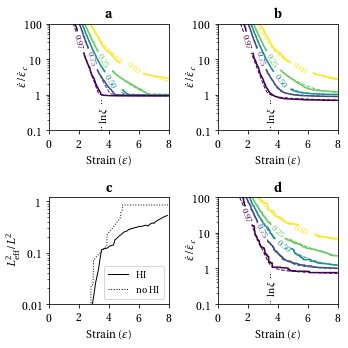

In [11]:
plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots(ncols=2, nrows=2)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]
#ccols = ['#dde318', '#5ec962', '#21918c', '#3b528b', '#440154']
epsilons = dataset['elongation_0_noBF']['epsilon']


CS1 = ax[0,0].contour(epsilons, ws, c_mono_model, levels, cmap='viridis_r', linestyles='dashed', linewidths=1)
CS = ax[0,0].contour(epsilons, ws, c_mono, levels, cmap='viridis_r')
ax[0,0].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0,0].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position], colors='w')
    ax[0,0].clabel(CS1, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
    
ax[0,0].set_xlabel(r'Strain ($\varepsilon$)')
ax[0,0].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[0,0].text(np.log(n_links)/2-0.2, 0.25, r'$\ln \xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[0,0].set_ylim(0.1, 100)
ax[0,0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0,0].set_xlim(0, 8)
ax[0,0].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[0,0].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[0,0].set_title(r'\textbf a')


CS1 = ax[0,1].contour(epsilons, ws, c_poly_model, levels, cmap='viridis_r', linestyles='dashed', linewidths=1)
CS = ax[0,1].contour(epsilons, ws, c_poly, levels, cmap='viridis_r')
ax[0,1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0,1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position], colors='w')
    ax[0,1].clabel(CS1, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
    
ax[0,1].set_xlabel(r'Strain ($\varepsilon$)')
ax[0,1].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[0,1].text(np.log(n_links)/2-0.2, 0.25, r'$\ln \xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[0,1].set_ylim(0.1, 100)
ax[0,1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0,1].set_xlim(0, 8)
ax[0,1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[0,1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[0,1].set_title(r'\textbf b')


ax[1,0].semilogy(dataset['HI']['t'][::10], dataset['HI']['L2'][36+1][::10], 'k-', linewidth=1, label='HI')
ax[1,0].semilogy(dataset['noHI']['t'], dataset['noHI']['L2'][1], 'k:', linewidth=1, label='no HI')
ax[1,0].set_xlim(0, 8)
ax[1,0].set_xticks(ticks=[0, 2, 4, 6, 8])
ax[1,0].set_xlabel(r'Strain ($\varepsilon$)')
ax[1,0].set_ylim(0.01, 1.2)
ax[1,0].set_ylabel(r'$L_\mathrm{eff}^2/L^2$', labelpad=0)
ax[1,0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1,0].legend(fontsize=10, loc='lower right')
ax[1,0].set_title(r'\textbf c')


CS1 = ax[1,1].contour(dataset['HI']['t'], ws, c_HI_model, levels, cmap='viridis_r', linestyles='dashed', linewidths=1)
CS = ax[1,1].contour(dataset['HI']['t'], ws, c_HI, levels, cmap='viridis_r')
ax[1,1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[1,1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position], colors='w')
    ax[1,1].clabel(CS1, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
    
ax[1,1].set_xlabel(r'Strain ($\varepsilon$)')
ax[1,1].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[1,1].text(np.log(n_links)/2-0.2, 0.25, r'$\ln \xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[1,1].set_ylim(0.1, 100)
ax[1,1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1,1].set_xlim(0, 8)
ax[1,1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[1,1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[1,1].set_title(r'\textbf d')


plt.tight_layout()
#plt.savefig('plot_distributions.pdf') 

## 3. Mechanochemical activation versus scission

Get the new distribution of intact chains given weak link at the center. We do that for two ratios of non-specific scission versus mechanophore activation: 2 (reported in the paper) and 5.

In [12]:
def get_distribution(data, ws, ratio):
    """Get distribution of intact chains from uniaxial elongation
    
    Parameters
    ----------
    data: dict
        Dictionary of imported bead-rod simulation.
    ws: ndarray
        Array of strain rates normalized by the critical strain rate for mechanophore activation.
    ratio: float
        Non-specific scission force versus mechanophore activation?
        
    Returns
    -------
    ndarray 
        Distribution of intact chains according to the bead-rod simulations.
    """
    
    n_ensemble = data['L2'].shape[0]
    
    c = np.zeros((len(ws), len(data['t'])))
    
    for i, w in enumerate(tqdm(ws)):
        events = np.zeros_like(data['t'])
        
        # Loop over molecules
        for molecule, center in zip(data['L2'], data['M2']):
            # Loop over time (this is long but prevents non monotonic effects)
            for j, (L2_, M2_) in enumerate(zip(molecule, center)):
                if L2_ > ratio/w or M2_>1./w:
                    events[j] += 1
                    break
        c[i] = 1. - np.cumsum(events)/n_ensemble
            
    return c


# Polydispersed enesemble with a ratio of 2
c_m_2 = get_distribution(dataset['elongation_0_noBF_DP1.01'], ws, 2)   

c_m_5 = get_distribution(dataset['elongation_0_noBF_DP1.01'], ws, 5)  

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

We need to find the new parameters of the model. For a force ratio of 2:

In [13]:
def loss(params):
    s = np.sum((c_m_2-build_model(params, dataset['elongation_0_noBF_DP1.01']['epsilon'], ws, 1000))**2)
    print(s, end='\r')
    return s


res = minimize(loss, [0.32, 0.6, 0.25, 0.1, 0.2])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['𝜅', '𝛼', '𝛽', '𝛾0', '𝛾1', ]
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

c_m_2_model = build_model(res.x, dataset['elongation_0_noBF_DP1.01']['epsilon'], ws, 1000)

# Save for later:
params_ratio2 = res.x

Optimization terminated successfully.
𝜅 = 0.333 ± 0.008
𝛼 = 0.598 ± 0.025
𝛽 = 0.213 ± 0.012
𝛾0 = 0.090 ± 0.006
𝛾1 = 0.180 ± 0.019


For a force ratio of 5:

In [14]:
def loss(params):
    s = np.sum((c_m_5-build_model(params, dataset['elongation_0_noBF_DP1.01']['epsilon'], ws, 1000))**2)
    print(s, end='\r')
    return s


res = minimize(loss, [0.3, 0.5, 0.2, 0.1, 0.2])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['𝜅', '𝛼', '𝛽', '𝛾0', '𝛾1', ]
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

c_m_5_model = build_model(res.x, dataset['elongation_0_noBF_DP1.01']['epsilon'], ws, 1000)

# Save for later:
params_ratio5 = res.x

Optimization terminated successfully.
𝜅 = 0.361 ± 0.009
𝛼 = 0.486 ± 0.024
𝛽 = 0.171 ± 0.014
𝛾0 = 0.087 ± 0.005
𝛾1 = 0.207 ± 0.023


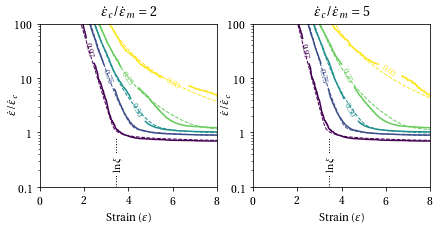

In [15]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(ncols=2)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]

epsilons = dataset['elongation_0_noBF']['epsilon']

ax[0].contour(epsilons, ws, c_m_2_model, levels, cmap='viridis_r', linestyles='dashed', linewidths=1)
CS = ax[0].contour(epsilons, ws, c_m_2, levels, cmap='viridis_r') # viridis_r, YlGnBu
ax[0].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[0].set_xlabel('Strain ($\\varepsilon$)')
ax[0].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[0].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[0].set_ylim(0.1, 100)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0].set_xlim(0, 8)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[0].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[0].set_title(r'$\dot\varepsilon_c/\dot\varepsilon_m=2$')

ax[1].contour(epsilons, ws, c_m_5_model, levels, cmap='viridis_r', linestyles='dashed', linewidths=1)
CS = ax[1].contour(epsilons, ws, c_m_5, levels, cmap='viridis_r')
ax[1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[1].set_xlabel('Strain ($\\varepsilon$)')
ax[1].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[1].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[1].set_ylim(0.1, 100)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[1].set_title(r'$\dot\varepsilon_c/\dot\varepsilon_m=5$')

plt.show()

### Efficiency

We consider the case where the force ratio, `ratio` = $\dot\varepsilon_c/\dot\varepsilon_m=2$. As described in the paper, we want to know, at every point in the intact chain map above, to proportion of chain that would produce activated mechanophore, versus non-specific scission, as we move through the map.

In [16]:
ratio = 2.

# Intact chains distribution will be re-computed as sanity check
intact_chains = np.zeros_like(c_m_2)

# Events are recorded in these tables:
dw_to_scission = np.zeros_like(c_m_2)
dw_to_mechanophore = np.zeros_like(c_m_2)
dh_to_scission = np.zeros_like(c_m_2)
dh_to_mechanophore = np.zeros_like(c_m_2)


data = dataset['elongation_0_noBF_DP1.01']
n_ensemble = data['L2'].shape[0]


for i, w in enumerate(tqdm(ws)):
    for j, h in enumerate(data['epsilon']):
        # Distributions
        L2s, M2s = data['L2'][:,j], data['M2'][:,j]
        
        # Conditional distribution for intact chains at point (i,j)
        T = (L2s < ratio/w) * (M2s < 1./w)
        intact_chains[i, j] = np.sum(T)/n_ensemble
        
        # Strain rate increment
        # ---------------------
        # Finite difference of i_step (reduce noise with bigger i_step)
        i_step = 2   
        if i < len(ws)-i_step:
            # From this point, we increase w
            # We consider only intact chains given by the mask T 
            # and test the conidtion for mechanophore activation
            T_dw = M2s[T] > 1/ws[i+i_step]
            dw_to_mechanophore[i, j] = np.sum(T_dw)/n_ensemble

            # We do the same for non-specific scission
            T_dw = (L2s[T] > ratio/ws[i+i_step]) * (M2s[T] < 1/ws[i+i_step])
            dw_to_scission[i, j] = np.sum(T_dw)/n_ensemble
        
        # Strain increment
        # ----------------
        j_step = 20
        if j < len(data['epsilon']) - j_step:
            # From this point we increase h and do similar process as above
            L2s, M2s = data['L2'][:,j+j_step], data['M2'][:,j+j_step]
            T_dh =  M2s[T] > 1/w
            dh_to_mechanophore[i, j] = np.sum(T_dh)/n_ensemble

            T_dh = (L2s[T] > ratio/w) * (M2s[T] < 1/w)
            dh_to_scission[i, j] = np.sum(T_dh)/n_ensemble

  0%|          | 0/100 [00:00<?, ?it/s]

### Plot result (figure 3)
Note: regions without scission nor mechanophore activation get `np.nan` values, and therefore are not colored in the plot.

We also test the non-specific scission threshold, $w_0$, given by:
\begin{equation}
    w_0 = \frac{\dot\varepsilon_m}{\dot\varepsilon_c} \left( 1 -\sqrt{1 - \frac{\dot\varepsilon_m}{\dot\varepsilon_c}} \right)^{-2}
    \label{eq:w0}
\end{equation}

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


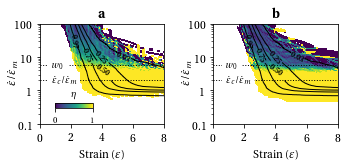

In [17]:
w_0 = 1/ratio*(1-np.sqrt(1-1/ratio))**(-2)


yield_dh = dh_to_mechanophore/(dh_to_mechanophore + dh_to_scission)
yield_dw = dw_to_mechanophore/(dw_to_mechanophore + dw_to_scission)
intact_chains_clear = intact_chains.copy()
intact_chains_clear[intact_chains_clear==1] = np.nan
intact_chains_clear[intact_chains_clear==0] = np.nan
intact_chains_clear[~np.isnan(intact_chains_clear)] = 0.05


plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots(ncols=2)

label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]

im1 = ax[0].pcolormesh(data['epsilon'], ws, yield_dh, rasterized=True)

CS = ax[0].contour(data['epsilon'], ws, c_m_2, levels, cmap='Greys_r', linewidths=1, vmin=0, vmax=100)
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=8, fmt='\\textbf{%1.2f}', manual=[position], inline_spacing=0)

ax[0].set_yscale('log')
ax[0].set_ylim(0.1, 100)
ax[0].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_m$', labelpad=-5)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0].set_xlim(0, 8)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8])
ax[0].set_xlabel('Strain ($\\varepsilon$)')

ax[0].axhline(ratio, ls=':', color='k', linewidth=1)
ax[0].text(0.8, 0.8*ratio, r'$\dot\varepsilon_c/\dot\varepsilon_m$', bbox={'fc': '1', 'ec': 'None'}, fontsize=10)

ax[0].axhline(w_0, ls=':', color='k', linewidth=1)
ax[0].text(0.8, 0.8*w_0, r'$w_0$', bbox={'fc': '1', 'ec': 'None'}, fontsize=10)

ax[0].set_title('\\textbf a')

axins1 = inset_axes(
    ax[0],
    width="30%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    borderpad=1.3
)
axins1.tick_params(labelsize=9)
axins1.set_title(r'$\eta$', fontsize=10)
fig.colorbar(im1, cax=axins1, orientation="horizontal", ticks=[0, 1])



CS = ax[1].contour(data['epsilon'], ws, c_m_2, levels, cmap='Greys_r', linewidths=1, vmin=0, vmax=100)
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=8, fmt='\\textbf{%1.2f}', manual=[position], inline_spacing=0)
ax[1].pcolormesh(data['epsilon'], ws, yield_dw, rasterized=True)

ax[1].axhline(ratio, ls=':', color='k', linewidth=1)
ax[1].text(0.8, 0.8*ratio, r'$\dot\varepsilon_c/\dot\varepsilon_m$', bbox={'fc': '1', 'ec': 'None'}, fontsize=10)

ax[1].axhline(w_0, ls=':', color='k', linewidth=1)
ax[1].text(0.8, 0.8*w_0, r'$w_0$', bbox={'fc': '1', 'ec': 'None'}, fontsize=10)

ax[1].set_yscale('log')
ax[1].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_m$', labelpad=-5)
ax[1].set_ylim(0.1, 100)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
ax[1].set_xlabel('Strain ($\\varepsilon$)')
ax[1].set_title('\\textbf b')

plt.tight_layout()
#plt.savefig('plot_efficiency.pdf', dpi=300) 
plt.show()

### Functional form of the efficiency

From the plot, we see that $\eta$ is largely independent of strain. There is a minor difference between an increase in strain or an increase in strain rate, but for simplicity we neglect this difference. Therefore we propose:
\begin{equation}
    %\eta(w) =  \left(1 + \left(\frac{w}{w_0} \right)^\frac{1}{\gamma_2} \right)^{-\gamma_2}
    -\ln \eta(w) = \gamma_2 G\left( \frac{\ln w - \ln w_0}{\gamma_2} \right)
    \label{eq:eta}
\end{equation}
with $\gamma_2\sim0.2$. 

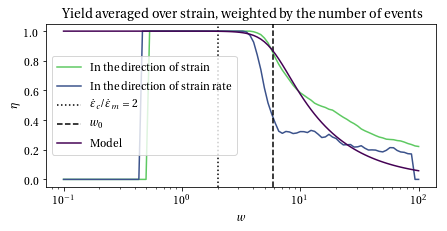

In [18]:
weights_h = dh_to_mechanophore + dh_to_scission + 1e-9
weights_w = dw_to_mechanophore + dw_to_scission + 1e-9
yield_dh2 = yield_dh.copy()
yield_dw2 = yield_dw.copy()
yield_dh2[np.isnan(yield_dh2)] = 0
yield_dw2[np.isnan(yield_dw2)] = 0

plt.rcParams['figure.figsize'] = [7, 3]

plt.semilogx(ws, np.average(yield_dh2, axis=1, weights=weights_h), '#5ec962', label='In the direction of strain')
plt.semilogx(ws, np.average(yield_dw2, axis=1, weights=weights_w), '#3b528b', label='In the direction of strain rate')
plt.axvline(ratio, ls=':', c='k', label=r'$\dot\varepsilon_c/\dot\varepsilon_m=2$')
plt.axvline(w_0, ls='--', c='k', label=r'$w_0$')

gamma_2 = 0.2
curve = np.exp(-gamma_2*np.log(1+np.exp(np.log(ws/w_0)/gamma_2)))

plt.semilogx(ws, curve, color='#440154', label='Model')
plt.legend()
plt.xlabel('$w$')
plt.ylabel('$\eta$')
plt.title('Yield averaged over strain, weighted by the number of events')
plt.show()

## 5. Model validation

We now test the model in different scenarios. All flows are obtained assuming Newtonian stress. Below are details on how the Lagrangian trajectories were obtained:

### 4:1 Contraction

This is a steady 2D-axisymmetric simulation done with OpenFOAM using a high-resolution mesh, at a Reynolds number of 100. Lagrangian trajectories are extracted at the post-processing step using Paraview. Initial seeds span from the centreline up to a small distance from the wall.

### Sonication

We follow the approach taken by Turetta and Lattuada (https://doi.org/10.1021/acs.iecr.1c00233), and solve the Rayleigh–Plesset equation:
$$
\rho\left(R\ddot{R} + \frac{3}{2}(\dot{R})^2\right)=\left(p_0 + \frac{2\sigma}{R_0}-p_v\right)\left(\frac{R_0}{R}\right)^{3\kappa} + p_v - \frac{2\sigma}{R} - \frac{4\eta\dot{R}}{R}-p_0-p_A(t)
$$
which can be rearranged as $y=(R, V)$ and:
$$
\begin{aligned}\dot{R}= & V\\
\dot{V}= & -\frac{3}{2}\frac{V^{2}}{R}+\frac{1}{\rho R}\left(\left(p_{0}+\frac{2\sigma}{R_{0}}-p_{v}\right)\left(\frac{R_{0}}{R}\right)^{3\kappa}+p_{v}-\frac{2\sigma}{R}-\frac{4\eta V}{R}-p_{0}-p_{A}(t)\right)
\end{aligned}
$$
Bellow is a code snippet to solve this equation in Python using the scipy `solve_ivp` function:

```python
from scipy.integrate import solve_ivp

R0 = 10e-6 # m
pv = 3.9e3 # Pa
p0 = 1.01325e5 #Pa
eta = 0.56e-3 #Pa.s
sigma = 0.028 #N/m
rho = 940 # kg/m^3
kappa = 1.4
p1 = p0 + 2*sigma/R0 - pv


pA = 5e5 # Pa
f = 20e3 # Hz

def forcing(t):
    return pA*np.sin(2*np.pi*f*t)

def RayleighPlesset(t, y):
    out = np.empty_like(y)
    out[0] = y[1]
    out[1] = -1.5*y[1]**2/y[0] + 1./(rho*y[0])*(p1*(R0/y[0])**3*(kappa)
                                                + pv - p0 
                                                - 2*sigma/y[0]
                                                - 4*eta*y[1]/y[0]
                                                - forcing(t)
                                               )
    return out
    
sol = solve_ivp(RayleighPlesset, (0, 100e-6), [R0, 0], max_step=1e-8)
```

To get Lagrangian strain rates, we define initial positions as:
$$ R_L(0) = \alpha R_0 $$
where $\alpha=1$ if the molecule is sitting at the bubble interface, $\alpha > 1$ otherwise. Using conservation of the volume of the shell between $R(t)$ and $R_L(t)$:
$$ R_L^3(t) = R(t)^3 + (\alpha^3-1) R_0^3 $$
The velocity at the bubble interface is just $\dot{R}(t)$. Again with conservation of volume, we have:
$$ U(r)r^2 = \dot{R}(t)R^2$$
And therefore:
$$ \frac{\partial U}{\partial r} = -2 \frac{\dot{R}(t)R^2}{r^3}$$
Finally, the Lagrangian strain rate is:
$$ \dot{\varepsilon}(\alpha, t) = -2 \frac{\dot{R}(t)R(t)^2}{R(t)^3 + (\alpha^3-1) R_0^3}$$
We let $\alpha$ vary from 1 to 10 to obtain different trajectories.

### Turbulence

Lagrangian trajectories are extracted from the open-access *Johns Hopkins Turbulence Databases* (see http://turbulence.pha.jhu.edu/datasets.aspx), using *Channel flow* data.

The notebook `JHTD_turbulence.ipynb` can generate trajectories stored in `npz` files. It can be run remotely on http://www.sciserver.org/. A de-noising step is necessary to remove interpolation noise.

### Inkjet

This flow is a 2D-axisymmetric simulation done with OpenFOAM using a high-resolution mesh and the Volume-of-Fluid method. The time-dependent flow rate is imposed at the inlet (far upstream of the nozzle) based on experimental measurements of a single nozzle Microfab system. Lagrangian trajectories are extracted at the post-processing step using Paraview. The video below displays the tracers as they pass the nozzle. The bottom window is the magnitude of the velocity gradient (in s<sup>-1</sup>) as a function of time (in s). The largest values are obtained by the tracer nearest to the wall (id=4), and the tracer on the centreline which is caught in the filament breakup (id=0). Bellow is a video showing the Lagrangian particles and the magnitude of the velocity gradient (in s<sup>-1</sup>).

In [19]:
%%HTML
<video width="600" height="360" controls>
  <source src="5tracers.ogv" type="video/mp4">
</video>

### Normalization step

For each flow scenario, the maximum dimensioned strain rate, $\dot\varepsilon_\max$, is extracted (as the maximum eigenvalue of the velocity gradient $\nabla \mathbf{u}$ of the combined trajectories). For the bead-rod model simulations, the number of links, $N$, (or average number of links for a polydispersed ensemble), and the maximum desired Weissenberg number, Wi$_\max$, are used to make a normalized velocity gradient as follows (see Rognin et al.  https://www.repository.cam.ac.uk/bitstream/1810/279443/1/multiscale_revision_clean.pdf):
$$
\nabla \mathbf{u}^+ = \frac{\nabla \mathbf{u}}{0.0142N^2\dot\varepsilon_\max}
$$
and the normalised time:
$$
t^+ = 0.0142N^2\dot\varepsilon_\max t
$$
In this study, we have Wi$_\max = 10^3$.

### Import data

Below we import simulations from the various scenarios. We also compute:
1. The conformation tensor from the FENE-P model `C`;
2. The effective strain rate `epsilon_dot_eff`;
3. The effective positive strain `epsilon_eff`;
4. The negative buckling strain `phi`.

Note that $\mathsf{C}$, $\varepsilon_{eff}$ and $\varphi$ are computed using an explicit Euler scheme (optionally with time step subdivision).

In [20]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 1000                      # Number of segments in the Kramers chain
n_ensemble = 100                     # Number of molecules to simulate

# Free-draining relaxation time
tau = 0.0142*n_links**2

# Scenarios for fine tuning
scenarios = [
    'contraction_0_PD',
    'contraction_2_PD',
    'contraction_4_PD',
    'contraction_5_PD',
    'contraction_6_PD',
    'sonication_0_PD',
    'sonication_1_PD',
    'sonication_2_PD',
    'sonication_3_PD',
    'sonication_4_PD',
    'turbulence_0_PD',
    'turbulence_1_PD',
    'turbulence_2_PD',
    'turbulence_3_PD',
    'turbulence_4_PD',
    'inkjet_0_PD',
    'inkjet_1_PD',
    'inkjet_2_PD',
    'inkjet_3_PD',
    'inkjet_4_PD',
]


for scenario in tqdm(scenarios):
    with np.load(f"{data_folder}/{scenario}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}.npz") as data:
        temp = dict(data)
        

        
        temp['∇U'] = temp.pop('gradU')
        temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
        
        # Conformation tensor from the bead-rod simulation:
        temp['A'] = temp.pop('A_average')
        temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
        
        # Conformation tensor from the FENE-P model:
        
        temp['C'] = np.zeros_like(temp['A'])
        temp['C'][0] = n_links*np.identity(3)/3
        
        # Rate of change in Conformation tensor according to FENE-P model
        def dC(it, dt, Cit):
            out = Cit @ temp['∇U'][it] + temp['∇U'][it].T @ Cit
            out += n_links*np.identity(3)/3/tau
            out += -Cit/tau/(1. - np.trace(Cit)/n_links**2)*(np.trace(Cit)+1)/np.trace(Cit)
            return dt*out
        
        for i, dt in enumerate(np.diff(temp['t'])):
            Cp = temp['C'][i]
            
            
            # Because the ODE is very stiff, we check if C is still positive.
            # For a better approach, use log-conformation formulation
            w, v = np.linalg.eigh(Cp)
            if any(w < 0):
                #print('Warning: loss in positiveness!')
                Cp = v @ np.diag(np.abs(w)) @ v.T
            
            # Also, we subdivide time steps
            if np.trace(Cp) > n_links**2/2:
                subdiv = 100
            else:
                subdiv = 10
                
            
            for j in range(subdiv): 
                Cp = Cp + dC(i, dt/subdiv, Cp)
            temp['C'][i+1] = Cp
               
        
        # Effective strain rate
        temp['tr(C)'] = np.trace(temp['C'], axis1=1, axis2=2)
        temp['tr(C∇U)'] = np.trace(temp['C']@temp['∇U'], axis1=1, axis2=2)  
        temp['epsilon_dot_eff'] = temp['tr(C∇U)']/temp['tr(C)']
        temp['epsilon_dot_eff_sim'] = np.trace(temp['A']@temp['∇U'], axis1=1, axis2=2) /temp['tr(A)']
        
        # Buckling strain
        phi = np.zeros_like(temp['t'])
        
        # Effective positive strain
        epsilon_eff = np.zeros_like(temp['t'])
        
        for i, dt in enumerate(np.diff(temp['t'])):
            
            # Buckling strain rate
            if temp['epsilon_dot_eff'][i] < 0 or phi[i] < -1e-6:
                epsilon_dot_b = temp['epsilon_dot_eff'][i]
            else:
                epsilon_dot_b = 0.
                
            subdiv = 10
            phip = phi[i]
            ep = epsilon_eff[i]
            for j in range(subdiv):
                phip = phip + dt/subdiv*(epsilon_dot_b - phip/tau)
                ep = ep + dt/subdiv*(temp['epsilon_dot_eff'][i] - epsilon_dot_b - ep/tau)
            epsilon_eff[i+1] = ep
            phi[i+1] = phip
        # temp['epsilon'] = epsilon
        temp['phi'] = phi
        temp['epsilon_eff'] = epsilon_eff


        # Save
        dataset[scenario] = temp

  0%|          | 0/20 [00:00<?, ?it/s]

Use the widget below to inspect the scenarios:

In [21]:
# Inspect
def view_inspect1(scenario, zoom):
    t = dataset[scenario]['t'][zoom[0]:zoom[1]]
    
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, ax = plt.subplots(nrows=3)
    ax[0].plot(t/tau, dataset[scenario]['tr(A)'][zoom[0]:zoom[1]], 'k', label='Trace of conformation tensor (simulation)')
    ax[0].plot(t/tau, dataset[scenario]['tr(C)'][zoom[0]:zoom[1]], 'k:', label='FENE-P')
    ax[0].set_xlabel(r'Time ($t/\tau$)')
    ax[0].legend()
    
    ax[1].semilogy(t/tau, tau*dataset[scenario]['epsilon_dot_eff'][zoom[0]:zoom[1]], label='From FENE-P projection')
    ax[1].semilogy(t/tau, tau*dataset[scenario]['epsilon_dot_eff_sim'][zoom[0]:zoom[1]], label='From bead-rod projection')

    ax[1].set_ylabel('Effective strain rate (Wi)')
    ax[1].set_xlabel(r'Time ($t/\tau$)')
    ax[1].set_ylim(0.5, 1000)
    ax[1].legend()
    
    
    ax[2].plot(t/tau, dataset[scenario]['epsilon_eff'][zoom[0]:zoom[1]], label='Positive strain')
    ax[2].plot(t/tau, dataset[scenario]['phi'][zoom[0]:zoom[1]], label='Buckling strain')
    ax[2].set_ylabel('Effective strain')
    ax[2].set_xlabel(r'Time ($t/\tau$)')
    ax[2].legend()
    
    plt.show()
    
    #plt.semilogy(dataset[scenario]['epsilon_eff'], tau*dataset[scenario]['epsilon_dot_eff'])

    
x_widget = widgets.Dropdown(options=scenarios, value=scenarios[0], description='Scenario:')
y_widget = widgets.IntRangeSlider(description='Zoom:', continuous_update=False)    

def update_models(*args):
    tmax = len(dataset[x_widget.value]['t'])
    y_widget.value=[0, tmax]
    y_widget.min=0
    y_widget.max=tmax
x_widget.observe(update_models)
    
inspect1 = interactive(view_inspect1, 
                 scenario=x_widget,
                 zoom=y_widget
                )
inspect1

interactive(children=(Dropdown(description='Scenario:', options=('contraction_0_PD', 'contraction_2_PD', 'cont…

### Define mechanochemistry model

In [22]:
# Cf paper notations
def F(x):
    return 1./(1 + np.exp(-x))

def G(x):
    return np.log(1. + np.exp(x))


gamma_2 = 0.2

def k_h(h, w):
    out = kappa*w**alpha
    out *= F(np.log(w)/gamma_0)
    out *= F((h + beta*np.log(w))/gamma_1)
    return out

def k_w(h, w):
    x1 = np.log(w)/gamma_0
    x2 = (h + beta*np.log(w))/gamma_1
    out = alpha*gamma_1*F(x1)*G(x2)
    out += gamma_1/gamma_0*F(x1)*F(-x1)*G(x2)
    out += beta*F(x1)*F(x2)
    return kappa*w**(alpha-1)*out
    
def eta(w):
    return (1 + (w/w_0)**(1./gamma_2))**(-gamma_2)
    

### Compute mechanochemistry from BD simulations

In [23]:
# Compute mechanochemistry for Lagrangian trajectories
Wi_m = 50
Wi_c = 100

if int(Wi_c/Wi_m)==1:
    kappa, alpha, beta, gamma_0, gamma_1 = params_ratio1
    
elif int(Wi_c/Wi_m)==2:
    kappa, alpha, beta, gamma_0, gamma_1 = params_ratio2
    
elif int(Wi_c/Wi_m)==5:
    kappa, alpha, beta, gamma_0, gamma_1 = params_ratio5
    
w_0 = Wi_m/Wi_c*(1-np.sqrt(1-Wi_m/Wi_c))**(-2)

# Critical tensions (in units of bead-rod model)

g_c = Wi_c/(8*0.0142)
g_m = Wi_m/(8*0.0142)


for scenario in tqdm(scenarios):
    
    t = dataset[scenario]['t']
    
    # Concentration of intact chains according to closure
    ci_model = np.ones_like(t)
    
    # Concentration of activated mechanophore (closure)
    cm_model = np.zeros_like(t)
    
    for i, (dt, dh, dw) in enumerate(zip(np.diff(t), np.diff(dataset[scenario]['epsilon_eff']), np.diff(dataset[scenario]['epsilon_dot_eff']*tau/Wi_m))):
        # Closure
        h = dataset[scenario]['epsilon_eff'][i] - 5./12*np.log(n_links)
        w = dataset[scenario]['epsilon_dot_eff'][i]*tau/Wi_m
        if w <= 0 or dh <= 0:
            k = 0
            eta_ = 0
        else:   
            k = max(0, k_h(h, w)*dh/dt + k_w(h, w)*dw/dt)
            eta_ = eta(w)
        # All events:
        ci_model[i+1] = ci_model[i]/(1. + dt*k)
        
        # Mechanophore:
        dc = ci_model[i+1] - ci_model[i]
        cm_model[i+1] = cm_model[i] - eta_*dc
        
    # BD simulation
    events = np.zeros_like(t)
    events_mech = np.zeros_like(t)
    
    for g_max_series, g_12_series in zip(dataset[scenario]['g_max'], dataset[scenario]['g_12']):
        for i, (g_max, g_12) in enumerate(zip(g_max_series, g_12_series)):           
            if g_12 > g_m:
                # Mechanophore activation
                events_mech[i] += 1
                events[i] += 1
                break
            
            if g_max > g_c:
                # Non-specific scission
                events[i] += 1
                break
                
    ci = 1. - np.cumsum(events)/n_ensemble
    cm = np.cumsum(events_mech)/n_ensemble
    
    dataset[scenario]['ci'] = ci
    dataset[scenario]['cm'] = cm
    
    dataset[scenario]['ci_model'] = ci_model
    dataset[scenario]['cm_model'] = cm_model
    
    dataset[scenario]['error2_m'] = np.sqrt(np.average((cm_model - cm)**2))
    dataset[scenario]['error2_i'] = np.sqrt(np.average((ci_model - ci)**2))
    dataset[scenario]['error1_m'] = np.average(np.abs(cm_model - cm))
    dataset[scenario]['error1_i'] = np.average(np.abs(ci_model - ci))
    dataset[scenario]['error0_m'] = np.amax(np.abs(cm_model - cm))
    dataset[scenario]['error0_i'] = np.amax(np.abs(ci_model - ci))


  0%|          | 0/20 [00:00<?, ?it/s]

### Plot error (figure 4)

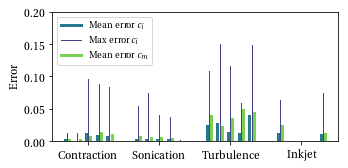

In [24]:
# Error analysis

plt.rcParams['figure.figsize'] = [5, 2.5]

# For a stacked bar chart
xs = {
    'contraction_0_PD': 0.7,
    'contraction_2_PD': 0.85,
    'contraction_4_PD': 1,
    'contraction_5_PD': 1.15,
    'contraction_6_PD': 1.3 ,
    'sonication_0_PD': 1.7,
    'sonication_1_PD': 1.85,
    'sonication_2_PD': 2,
    'sonication_3_PD': 2.15,
    'sonication_4_PD': 2.3,
    'turbulence_0_PD': 2.7,
    'turbulence_1_PD': 2.85,
    'turbulence_2_PD': 3,
    'turbulence_3_PD': 3.15,
    'turbulence_4_PD': 3.3,
    'inkjet_0_PD': 3.7,
    'inkjet_1_PD': 3.85,
    'inkjet_2_PD': 4,
    'inkjet_3_PD': 4.15,
    'inkjet_4_PD': 4.3,
}

def colo(scenario):
    if scenario.startswith("sonication"):
        return '#7ad151'
    elif scenario.startswith("contraction"):
        return '#2a788e'
    elif scenario.startswith("inkjet"):
        return '#414487'
    elif scenario.startswith("turbulence"):
        return '#fde725'
    else:
        return 'k'
    
first_iter = True
for scenario in scenarios:
    if first_iter:
        labs = ['Mean error $c_i$', 'Max error $c_i$', 'Mean error $c_m$']
    else:
        labs = [None]*3
    plt.plot([xs[scenario]-0.03, xs[scenario]-0.03], [0, dataset[scenario]['error1_i']], c='#2a788e', lw=3, label=labs[0])
    plt.plot([xs[scenario], xs[scenario]], [0, dataset[scenario]['error0_i']], lw=1, c='#414487', label=labs[1])
    plt.plot([xs[scenario]+0.03, xs[scenario]+0.03], [0, dataset[scenario]['error1_m']], c='#7ad151', lw=3, label=labs[2])

    first_iter = False

plt.ylabel('Error')
plt.ylim(0, 0.2)
#plt.yscale('log')
plt.xticks([1, 2, 3, 4], ['Contraction', 'Sonication', 'Turbulence', 'Inkjet'], rotation=0, ha='center')
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
#plt.savefig('plot_closure_test.pdf') 
plt.show()

Use the widget below to inpect the results of the mechanophore activation model:

In [25]:
# Inspect
def view_inspect2(scenario, zoom):
    t = dataset[scenario]['t'][zoom[0]:zoom[1]]
    
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, ax = plt.subplots(nrows=3)
    ax[0].plot(t/tau, dataset[scenario]['ci'][zoom[0]:zoom[1]], 'k', label='Intact chains')
    ax[0].plot(t/tau, dataset[scenario]['ci_model'][zoom[0]:zoom[1]], 'k:', label='Intact chains (closure)')
    ax[0].plot(t/tau, dataset[scenario]['cm'][zoom[0]:zoom[1]], 'r', label='Mechanophore')
    ax[0].plot(t/tau, dataset[scenario]['cm_model'][zoom[0]:zoom[1]], 'r:', label='Mechanophore (closure)')
    ax[0].set_ylabel('Concentration')
    ax[0].set_xlabel(r'Time ($t/\tau$)')
    ax[0].legend()
    
    ax[1].plot(t/tau, dataset[scenario]['epsilon_eff'][zoom[0]:zoom[1]], label='Positive strain')
    ax[1].plot(t/tau, dataset[scenario]['phi'][zoom[0]:zoom[1]], label='Buckling strain')
    ax[1].set_ylabel('Effective strain')
    ax[1].set_xlabel(r'Time ($t/\tau$)')
    ax[1].legend()
    
    ax[2].semilogy(t/tau, tau*dataset[scenario]['epsilon_dot_eff'][zoom[0]:zoom[1]])
    ax[2].axhline(Wi_c, ls='--', c='red', label='Scission')
    ax[2].axhline(Wi_m, ls=':', c='orange', label='Mechanophore')
    ax[2].axhline(Wi_m*w_0, ls='--', c='k', label='$w_0$')

    ax[2].set_ylabel('Effective strain rate')
    ax[2].set_xlabel(r'Time ($t/\tau$)')
    ax[2].set_ylim(1, 1000)
    ax[2].legend()
    
    plt.show()

    
x_widget = widgets.Dropdown(options=scenarios, value=scenarios[0], description='Scenario:')
y_widget = widgets.IntRangeSlider(description='Zoom:', continuous_update=False)    

def update_models(*args):
    tmax = len(dataset[x_widget.value]['t'])
    y_widget.value=[0, tmax]
    y_widget.min=0
    y_widget.max=tmax
x_widget.observe(update_models)
    
inspect2 = interactive(view_inspect2, 
                 scenario=x_widget,
                 zoom=y_widget
                )
inspect2

interactive(children=(Dropdown(description='Scenario:', options=('contraction_0_PD', 'contraction_2_PD', 'cont…

### Example used in the paper (figure 5)

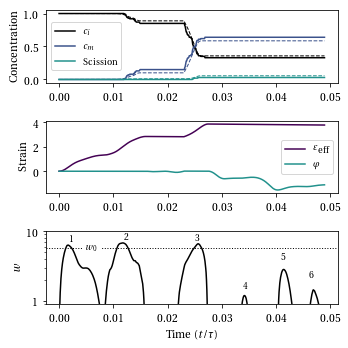

In [26]:
# Example output
scenario = 'turbulence_0_PD'
t = dataset[scenario]['t']/tau

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots(nrows=3)
ax[0].plot(t, dataset[scenario]['ci'], 'k', label=r'$c_i$')
ax[0].plot(t, dataset[scenario]['ci_model'], 'k--', lw=1)
ax[0].plot(t, dataset[scenario]['cm'], c='#3b528b', label=r'$c_m$')
ax[0].plot(t, dataset[scenario]['cm_model'], c='#3b528b', ls='--', lw=1)
ax[0].plot(t, 1-dataset[scenario]['ci']-dataset[scenario]['cm'], c='#21918c', label=r'Scission')
ax[0].plot(t, 1-dataset[scenario]['ci_model']-dataset[scenario]['cm_model'], c='#21918c', ls='--', lw=1)
ax[0].set_ylabel(r'Concentration')
#ax[0].set_xlabel(r'Time ($t/\tau$)')
ax[0].legend(fontsize=10, loc='center left')

ax[1].plot(t, dataset[scenario]['epsilon_eff'], c='#440154', label=r'$\varepsilon_\textrm{eff}$')
ax[1].plot(t, dataset[scenario]['phi'], c='#21918c', label=r'$\varphi$')
ax[1].set_ylabel('Strain')
#ax[1].set_xlabel(r'Time ($t/\tau$)')
ax[1].legend(fontsize=10, loc='center right')


ax[2].axhline(w_0, ls=':', c='k', linewidth=1)
ax[2].text(0.005, 0.9*w_0, r'$w_0$', bbox={'fc': '1', 'ec': 'None'}, fontsize=10)

ax[2].text(0.002, 1.2*w_0, '1', fontsize=10)
ax[2].text(0.012, 1.3*w_0, '2', fontsize=10)
ax[2].text(0.025, 1.25*w_0, '3', fontsize=10)
ax[2].text(0.034, 1.5, '4', fontsize=10)
ax[2].text(0.041, 4, '5', fontsize=10)
ax[2].text(0.046, 2.2, '6', fontsize=10)

ax[2].semilogy(t, tau*dataset[scenario]['epsilon_dot_eff']/Wi_m, 'k')
ax[2].set_ylim(0.9, 10)



ax[2].set_ylabel(r'$w$')
ax[2].set_xlabel(r'Time ($t/\tau$)')
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.tight_layout()
#plt.savefig('plot_results.pdf')
plt.show()

### Whole set of trajectories

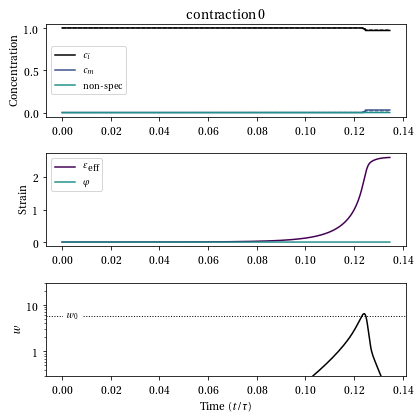

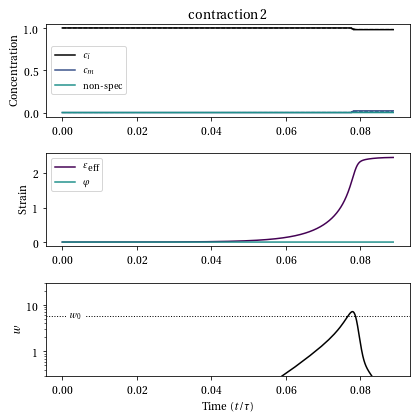

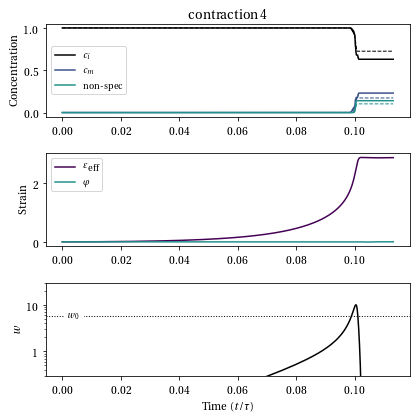

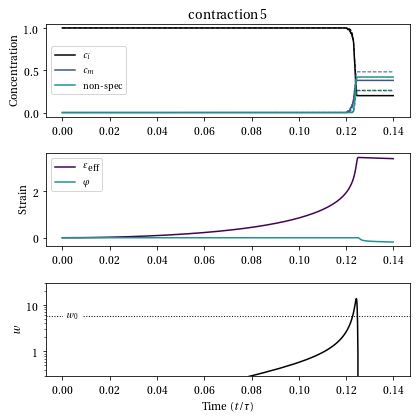

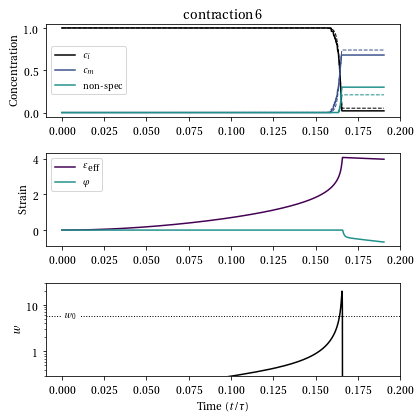

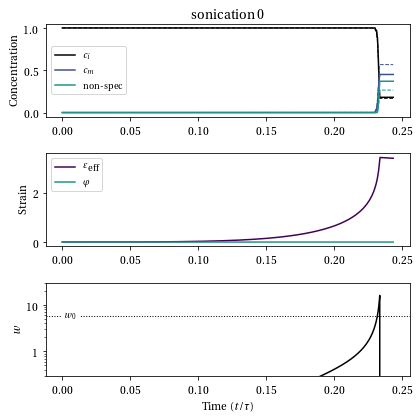

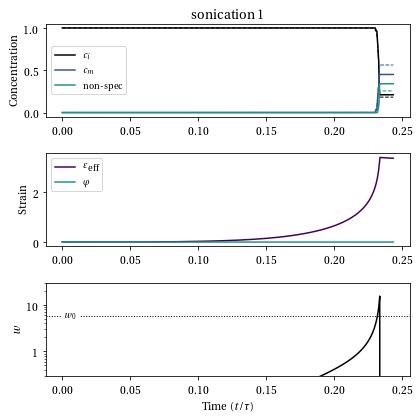

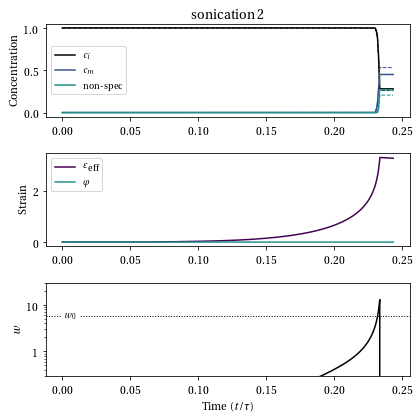

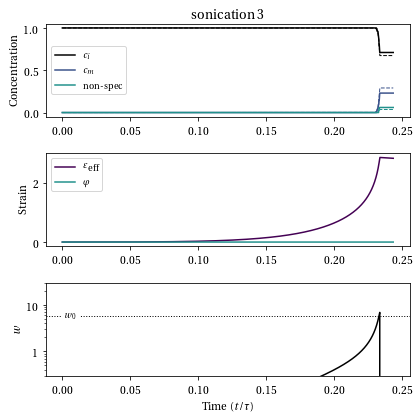

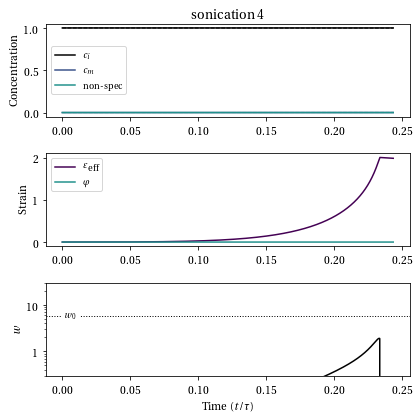

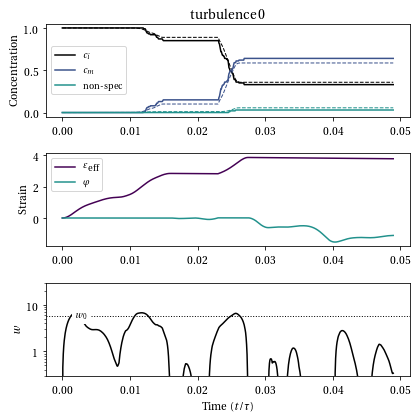

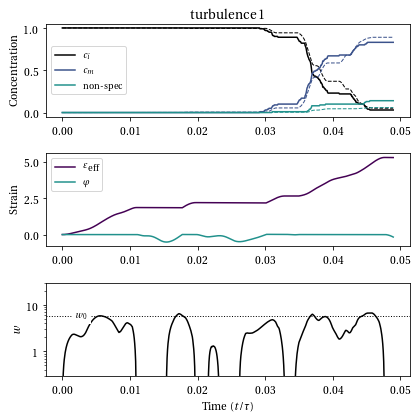

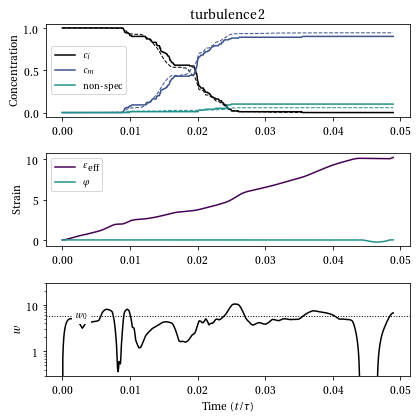

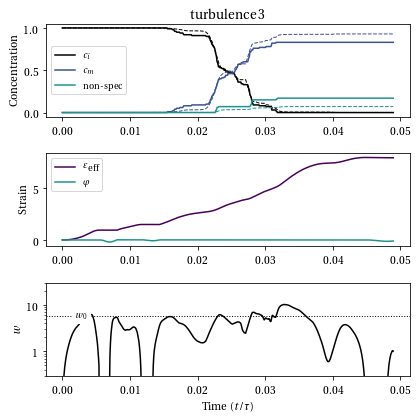

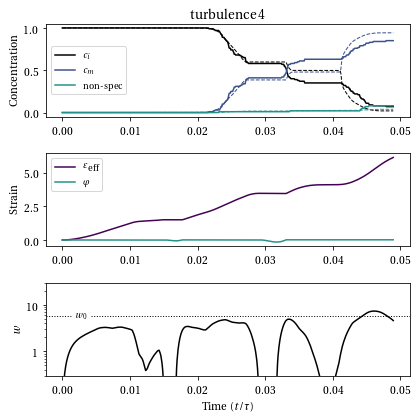

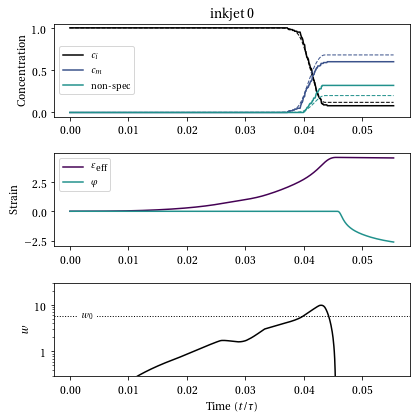

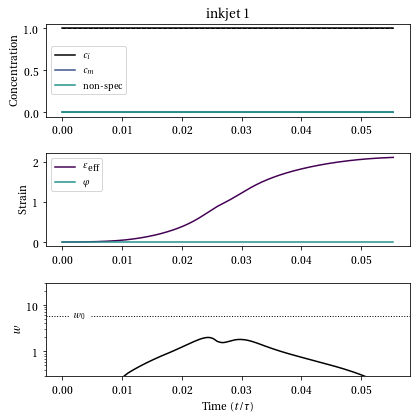

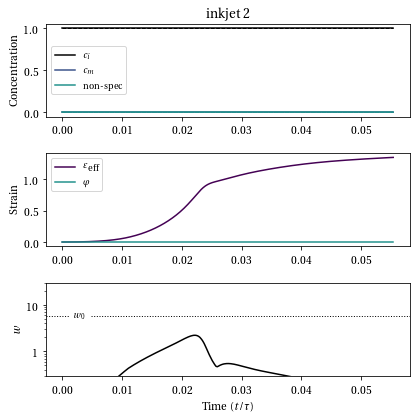

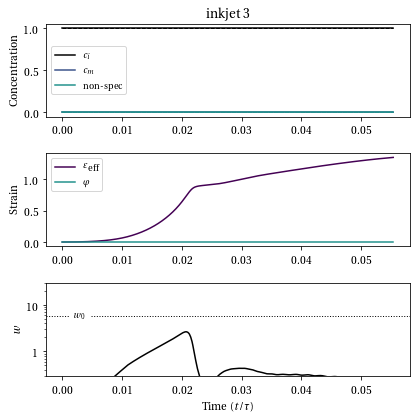

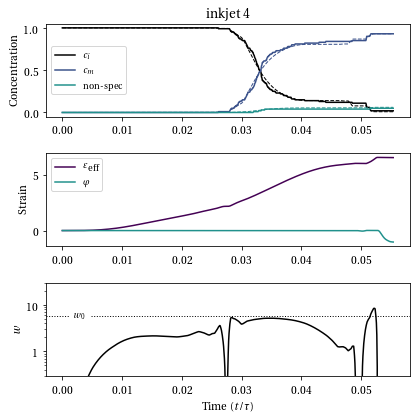

In [27]:
# Example output
for scenario in scenarios:

    t = dataset[scenario]['t']/tau

    plt.rcParams['figure.figsize'] = [6, 6]
    fig, ax = plt.subplots(nrows=3)
    ax[0].set_title(' '.join(scenario.split('_')[:-1]))
    ax[0].plot(t, dataset[scenario]['ci'], 'k', label=r'$c_i$')
    ax[0].plot(t, dataset[scenario]['ci_model'], 'k--', lw=1)
    ax[0].plot(t, dataset[scenario]['cm'], c='#3b528b', label=r'$c_m$')
    ax[0].plot(t, dataset[scenario]['cm_model'], c='#3b528b', ls='--', lw=1)
    ax[0].plot(t, 1-dataset[scenario]['ci']-dataset[scenario]['cm'], c='#21918c', label=r'non-spec')
    ax[0].plot(t, 1-dataset[scenario]['ci_model']-dataset[scenario]['cm_model'], c='#21918c', ls='--', lw=1)
    ax[0].set_ylabel('Concentration')
    ax[0].legend(fontsize=10, loc='center left')

    ax[1].plot(t, dataset[scenario]['epsilon_eff'], c='#440154', label=r'$\varepsilon_\textrm{eff}$')
    ax[1].plot(t, dataset[scenario]['phi'], c='#21918c', label=r'$\varphi$')
    ax[1].set_ylabel('Strain')
    ax[1].legend(fontsize=10, loc='upper left')


    ax[2].axhline(w_0, ls=':', c='k', linewidth=1)
    ax[2].text(0.002, 0.9*w_0, r'$w_0$', bbox={'fc': '1', 'ec': 'None'}, fontsize=10)

    ax[2].semilogy(t, tau*dataset[scenario]['epsilon_dot_eff']/Wi_m, 'k')
    ax[2].set_ylim(0.3, 30)



    ax[2].set_ylabel(r'$w$')
    ax[2].set_xlabel(r'Time ($t/\tau$)')
    ax[2].yaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.tight_layout()
    
    plt.show()